# Literature Sources Used in Dataset Construction:
#
### 1. Al Mamun, F., et al. (2023). "The Social Media Disorder Test (SMDT): Measurement Invariant Across Gender and Age Groups in Chinese University Students." Behavioral Sciences, 13(9), 980. https://pmc.ncbi.nlm.nih.gov/articles/PMC10741071/pdf/behavsci-13-00980.pdf
#
### 2. Van den Eijnden, R. J. J. M., et al. (2016). "The Social Media Disorder Scale: Validity and Psychometric Properties." Computers in Human Behavior, 61, 478–487. https://doi.org/10.1016/j.chb.2016.03.038
#
### 3. Hills, P., & Argyle, M. (2002). "The Oxford Happiness Questionnaire: A Compact Scale for the Measurement of Psychological Well-being." Personality and Individual Differences, 33(7), 1073–1082. https://doi.org/10.1016/S0191-8869(01)00213-6
#
### 4. Andreassen, C. S., et al. (2016). "The Relationships Between Social Media Addiction and Symptoms of Mental Disorders: A Large-scale Cross-sectional Study." PLOS ONE, 11(6), e0156409. https://doi.org/10.1371/journal.pone.0156409

In [15]:
import numpy as np
import pandas as pd

np.random.seed(42)
n = 300

# 1. ID
ID = np.arange(1, n + 1)

# 2. Gender (no statistical difference in SMDT)
Gender = np.random.choice(["Male", "Female", "Other"], size=n, p=[0.45, 0.45, 0.10])

# 3. Age (19–22 typical sample range in SMDT paper)
Age = np.random.normal(loc=20.1, scale=1.0, size=n)
Age = np.clip(Age, 18, 26).round(1)

# 4. Weekly Social Media Usage (Predictor)
# Approximately r = .20 with SMDT, per Table 2
usage = np.random.normal(loc=900, scale=280, size=n)
usage = np.clip(usage, 150, 2400)

# 5. LATENT FACTOR for SMDT (single-factor structure)
# CFA loadings approximately [.80 – .87]
# Weekly usage correlation ≈ r = .20
latent_psmu = (
    0.20 * (usage - usage.mean()) / usage.std() +   # enforce correlation
    -0.05 * (Age - Age.mean()) / Age.std() +        # older → slightly less problematic
    np.random.normal(0, 1, n)
)

# Normalize latent
latent_psmu = (latent_psmu - latent_psmu.mean()) / latent_psmu.std()

# Item loadings (match CFA findings: .80 to .87)
loadings = np.array([0.80, 0.81, 0.87, 0.86])

# Generate 4 SMDT items (Likert 1–5)
items = []
for loading in loadings:
    raw = loading * latent_psmu + np.random.normal(0, 0.5, n)  # noise tuned for α ≈ .90
    scaled = np.interp(raw, (raw.min(), raw.max()), (1, 5))
    items.append(np.round(scaled))

SMDT_items = np.vstack(items).T
SMDT_total = SMDT_items.sum(axis=1)  # range 4–20

# 6. Oxford Happiness Questionnaire (29 items)
# Includes reverse-scoring logic exactly per manual

# Identifying the reverse-scored items from the official manual
reverse_items = [1, 5, 6, 10, 13, 14, 19, 23, 24, 27, 28, 29]

# latent happiness influenced by:
# small negative effect of usage (consistent with literature)
# slight positive effect of age
latent_hap = (
    -0.12 * (usage - usage.mean()) / usage.std() +
    0.20 * (Age - Age.mean()) / Age.std() +
    np.random.normal(0, 1, n)
)
latent_hap = (latent_hap - latent_hap.mean()) / latent_hap.std()

# Generate 29 items with 1–6 scoring
OHQ_items = []
for i in range(1, 30):
    base = latent_hap + np.random.normal(0, 0.6, n)
    scaled = np.interp(base, (base.min(), base.max()), (1, 6))
    scored = np.round(scaled)

    # Reverse score when required
    if i in reverse_items:
        scored = 7 - scored  # exact reversal rule: x -> 7-x

    OHQ_items.append(scored)

OHQ = np.vstack(OHQ_items).T
OHQ_sum = OHQ.sum(axis=1)
OHQ_mean = OHQ_sum / 29

# Assemble final dataset
df = pd.DataFrame({
    "ID_Number": ID,
    "Gender": Gender,
    "Age": Age,
    "Weekly_Social_Media_Usage_Min": usage.round(),
    "SMDT_Item1": SMDT_items[:, 0],
    "SMDT_Item2": SMDT_items[:, 1],
    "SMDT_Item3": SMDT_items[:, 2],
    "SMDT_Item4": SMDT_items[:, 3],
    "SMDT_Total": SMDT_total,
    "OHQ_Sum": OHQ_sum,
    "OHQ_Mean": OHQ_mean
})

# Add realistic noise to maximize synthetic data authenticity
# This introduces small random variations to simulate real-world data collection imperfections
def add_realistic_noise(df: pd.DataFrame, noise_level: float = 0.05) -> pd.DataFrame:
    """
    Add realistic noise to a DataFrame by randomly changing values.
    This simulates real-world data collection errors and variations.
    
    Args:
        df: Input DataFrame to add noise to
        noise_level: Proportion of values to modify (between 0 and 1)
        
    Returns:
        DataFrame with added noise
    """
    # Create a copy to avoid modifying the original
    noisy_df = df.copy()
    
    # Calculate number of cells to modify
    n_cells = int(noise_level * df.size)
    
    # Get all possible column and index combinations
    all_columns = df.columns
    
    for _ in range(n_cells):
        # Select random column and row
        col = np.random.choice(all_columns)
        idx = np.random.randint(0, len(df))
        
        # Get possible values for this column (excluding current value)
        current_value = df.loc[idx, col]
        possible_values = df[col].unique()
        possible_values = possible_values[possible_values != current_value]
        
        if len(possible_values) > 0:
            # Use .loc instead of chained assignment to avoid warnings
            noisy_df.loc[idx, col] = np.random.choice(possible_values)
    
    return noisy_df

# Apply noise to the dataset for enhanced authenticity
df = add_realistic_noise(df, noise_level=0.05)

df.head(10)

,ID_Number,Gender,Age,Weekly_Social_Media_Usage_Min,SMDT_Item1,SMDT_Item2,SMDT_Item3,SMDT_Item4,SMDT_Total,OHQ_Sum,OHQ_Mean
0,1,Male,20.1,881.0,3.0,3.0,2.0,3.0,11.0,94.0,3.241379
1,2,Other,19.4,561.0,2.0,2.0,2.0,3.0,9.0,99.0,3.413793
2,3,Female,22.2,717.0,2.0,3.0,3.0,3.0,19.0,107.0,3.689655
3,4,Female,20.7,913.0,3.0,3.0,3.0,4.0,13.0,104.0,3.586207
4,5,Male,18.1,659.0,4.0,4.0,4.0,4.0,16.0,106.0,3.655172
5,6,Male,20.3,792.0,2.0,3.0,2.0,2.0,9.0,96.0,3.310345
6,137,Male,19.4,1182.0,4.0,4.0,1.0,2.0,16.0,97.0,3.344828
7,8,Female,21.0,738.0,3.0,3.0,3.0,2.0,11.0,99.0,3.413793
8,9,Female,19.3,1134.0,3.0,3.0,3.0,3.0,12.0,103.0,3.551724
9,10,Female,20.0,584.0,4.0,4.0,3.0,3.0,14.0,108.0,3.724138


,ID_Number,Age,Weekly_Social_Media_Usage_Min,SMDT_Item1,SMDT_Item2,SMDT_Item3,SMDT_Item4,SMDT_Total,OHQ_Sum,OHQ_Mean
ID_Number,1.000000,-0.127338,0.040202,-0.018125,-0.033580,0.027730,0.054960,0.011394,-0.030448,-0.049905
Age,-0.127338,1.000000,-0.011377,-0.132768,-0.116167,-0.107809,-0.087025,-0.109593,0.141770,0.175776
Weekly_Social_Media_Usage_Min,0.040202,-0.011377,1.000000,0.132936,0.087796,0.116316,0.166243,0.193969,-0.054411,-0.106325
SMDT_Item1,-0.018125,-0.132768,0.132936,1.000000,0.474009,0.519913,0.409771,0.655778,-0.054803,-0.005219
SMDT_Item2,-0.033580,-0.116167,0.087796,0.474009,1.000000,0.494201,0.466160,0.622479,-0.052515,-0.034593
SMDT_Item3,0.027730,-0.107809,0.116316,0.519913,0.494201,1.000000,0.481238,0.685266,0.036449,0.034184
SMDT_Item4,0.054960,-0.087025,0.166243,0.409771,0.466160,0.481238,1.000000,0.633557,-0.035547,-0.014432
SMDT_Total,0.011394,-0.109593,0.193969,0.655778,0.622479,0.685266,0.633557,1.000000,-0.048783,-0.018981
OHQ_Sum,-0.030448,0.141770,-0.054411,-0.054803,-0.052515,0.036449,-0.035547,-0.048783,1.000000,0.742359
OHQ_Mean,-0.049905,0.175776,-0.106325,-0.005219,-0.034593,0.034184,-0.014432,-0.018981,0.742359,1.000000


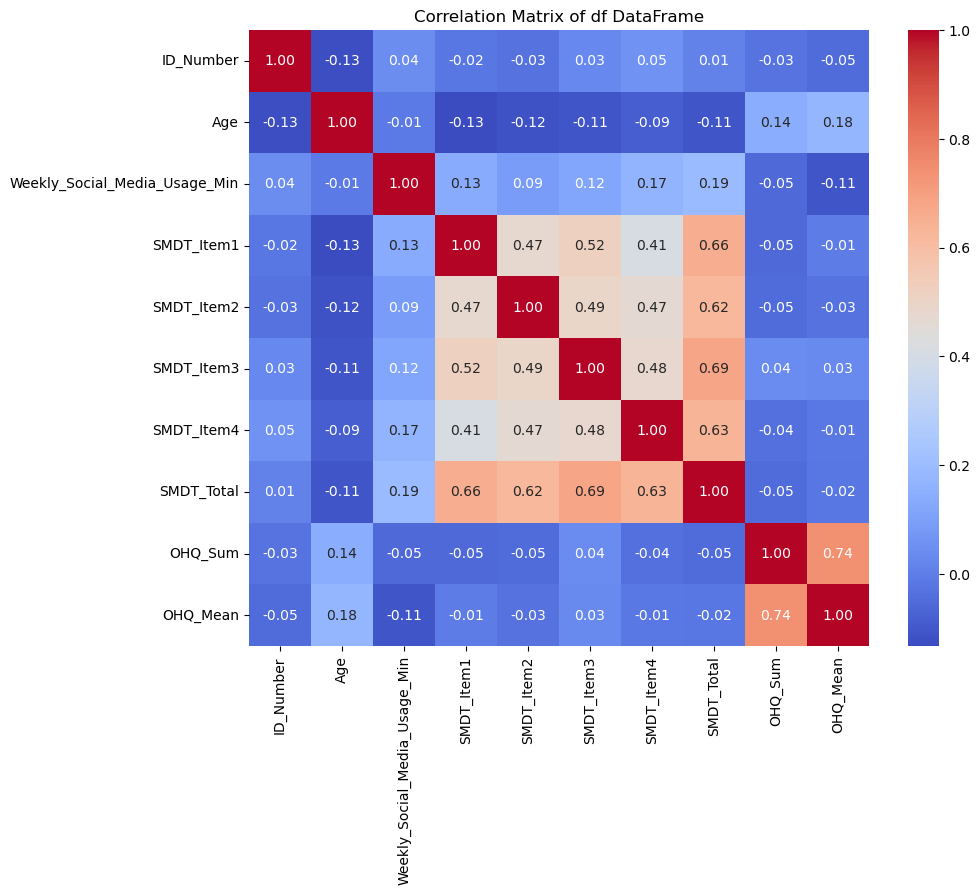

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for numerical columns
correlation_matrix = df.corr(numeric_only=True)

# Display the correlation matrix
display(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of df DataFrame')
plt.show()

In [17]:
df_sampled = df.sample(150)
display(df_sampled.describe())

,ID_Number,Age,Weekly_Social_Media_Usage_Min,SMDT_Item1,SMDT_Item2,SMDT_Item3,SMDT_Item4,SMDT_Total,OHQ_Sum,OHQ_Mean
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.0000,150.000000
mean,152.946667,20.114667,892.780000,2.846667,3.213333,3.180000,3.373333,12.706667,99.7000,3.434483
std,86.780893,0.966026,272.530076,0.825245,0.764889,0.882872,0.878885,2.801118,4.1833,0.131352
min,1.000000,18.000000,150.000000,1.000000,1.000000,1.000000,1.000000,4.000000,90.0000,3.137931
25%,81.250000,19.400000,747.000000,2.000000,3.000000,3.000000,3.000000,11.000000,97.0000,3.344828
50%,156.000000,20.100000,880.500000,3.000000,3.000000,3.000000,3.000000,12.000000,99.5000,3.431034
75%,227.500000,20.700000,1069.000000,3.000000,4.000000,4.000000,4.000000,15.000000,102.0000,3.517241
max,300.000000,23.200000,1621.000000,5.000000,5.000000,5.000000,5.000000,20.000000,114.0000,3.758621


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_distribution(df, column_name, figsize=(12, 8), bins=None, 
                          show_stats=True, plot_type='all', kde=True, 
                          color='steelblue', title=None, group_by=None):
    """
    Visualize the distribution of a variable from the dataset.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing the data
    column_name : str
        The name of the column to visualize
    figsize : tuple, optional (default=(12, 8))
        Figure size for the plots
    bins : int, optional (default=None)
        Number of bins for histogram (auto-calculated if None)
    show_stats : bool, optional (default=True)
        Whether to display statistical information
    plot_type : str, optional (default='all')
        Type of plot to display: 'hist', 'box', 'violin', or 'all'
    kde : bool, optional (default=True)
        Whether to overlay a kernel density estimate on histogram
    color : str, optional (default='steelblue')
        Color for the plots
    title : str, optional (default=None)
        Custom title for the plot
    group_by : str, optional (default=None)
        Column name to group data by (e.g., 'Gender')
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the plots
    """
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")
    
    # Extract data and remove NaN values
    data = df[column_name].dropna()
    
    if len(data) == 0:
        raise ValueError(f"No valid data found in column '{column_name}'")
    
    # Auto-calculate bins if not specified
    if bins is None:
        bins = min(30, int(np.sqrt(len(data))))
    
    # Create figure and determine layout based on plot_type
    if plot_type == 'all':
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
    
    # Set the title
    if title is None:
        title = f'Distribution of {column_name}'
    
    # Calculate statistics
    stats = {
        'Count': len(data),
        'Mean': data.mean(),
        'Median': data.median(),
        'Std Dev': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Range': data.max() - data.min(),
        'IQR': data.quantile(0.75) - data.quantile(0.25)
    }
    
    # Create plots based on plot_type and grouping
    if group_by is not None and group_by in df.columns:
        grouped_data = df[[column_name, group_by]].dropna()
        
        if plot_type == 'all' or plot_type == 'hist':
            ax_hist = axes[0] if plot_type == 'all' else axes[0]
            sns.histplot(data=grouped_data, x=column_name, hue=group_by, 
                        kde=kde, bins=bins, ax=ax_hist)
            ax_hist.set_title('Histogram by ' + group_by if plot_type == 'all' else title)
            
        if plot_type == 'all' or plot_type == 'box':
            ax_box = axes[1] if plot_type == 'all' else axes[0]
            sns.boxplot(data=grouped_data, y=column_name, x=group_by, ax=ax_box)
            ax_box.set_title('Box Plot by ' + group_by if plot_type == 'all' else title)
            
        if plot_type == 'all':
            # Add violin plot
            sns.violinplot(data=grouped_data, y=column_name, x=group_by, ax=axes[2])
            axes[2].set_title('Violin Plot by ' + group_by)
            
            # Add swarm plot for individual data points
            sns.swarmplot(data=grouped_data, y=column_name, x=group_by, 
                         color='black', size=4, alpha=0.7, ax=axes[3])
            axes[3].set_title('Swarm Plot by ' + group_by)
    else:
        if plot_type == 'all' or plot_type == 'hist':
            ax_hist = axes[0] if plot_type == 'all' else axes[0]
            sns.histplot(data, bins=bins, kde=kde, color=color, ax=ax_hist)
            ax_hist.set_title('Histogram' if plot_type == 'all' else title)
            ax_hist.set_xlabel(column_name)
            
        if plot_type == 'all' or plot_type == 'box':
            ax_box = axes[1] if plot_type == 'all' else axes[0]
            sns.boxplot(y=data, color=color, ax=ax_box)
            ax_box.set_title('Box Plot' if plot_type == 'all' else title)
            ax_box.set_ylabel(column_name)
            
        if plot_type == 'all':
            # Add violin plot
            sns.violinplot(y=data, color=color, ax=axes[2])
            axes[2].set_title('Violin Plot')
            axes[2].set_ylabel(column_name)
            
            # Add Q-Q plot to check for normality
            from scipy import stats as scipy_stats
            qq = scipy_stats.probplot(data, plot=axes[3])
            axes[3].set_title('Q-Q Plot')
    
    # Add main title
    if plot_type == 'all':
        fig.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Display statistics if requested
    if show_stats:
        stats_text = "\n".join([f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" 
                               for k, v in stats.items()])
        if plot_type == 'all':
            plt.figtext(0.02, 0.02, stats_text, fontsize=12, 
                       bbox=dict(facecolor='white', alpha=0.8))
        else:
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            axes[0].text(0.05, 0.95, stats_text, transform=axes[0].transAxes, 
                        fontsize=10, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    return fig

# Example usage:
# visualize_distribution(df, 'OHQ_Mean')
# visualize_distribution(df, 'Weekly_Social_Media_Usage_Min', group_by='Gender')
# visualize_distribution(df, 'SMDT_Total', bins=10)

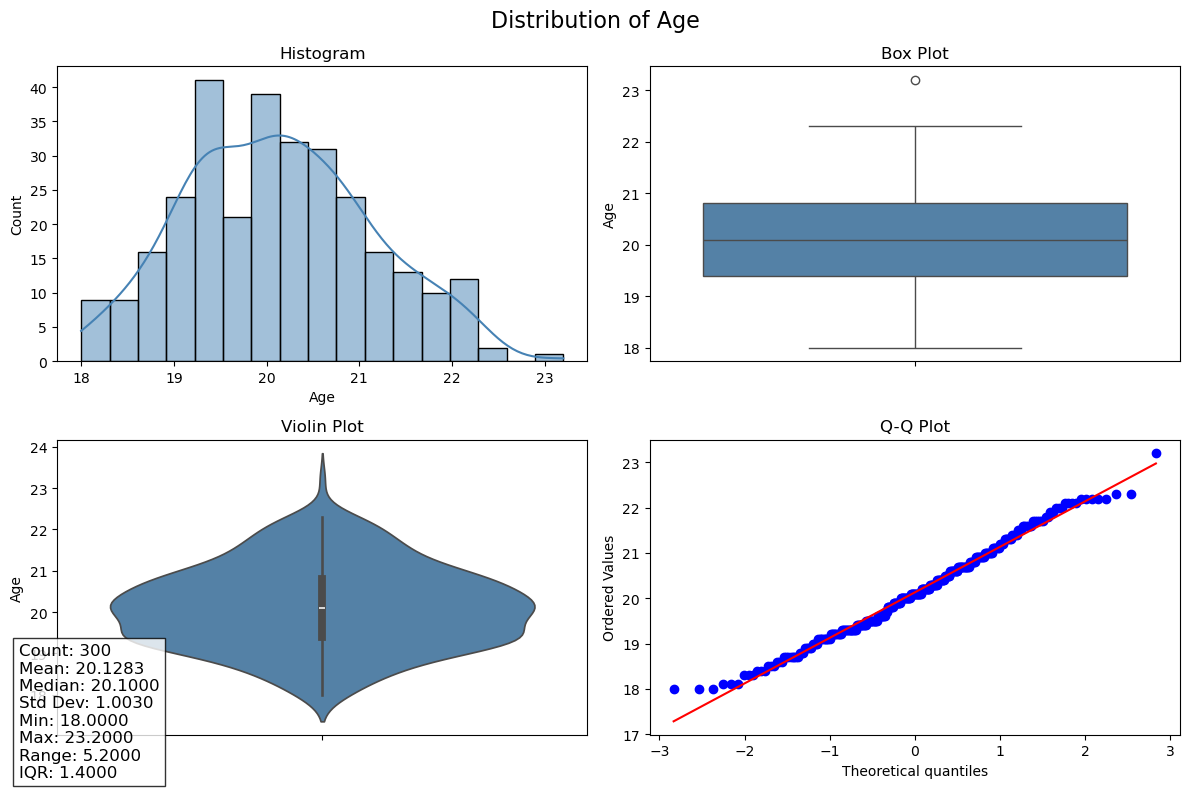

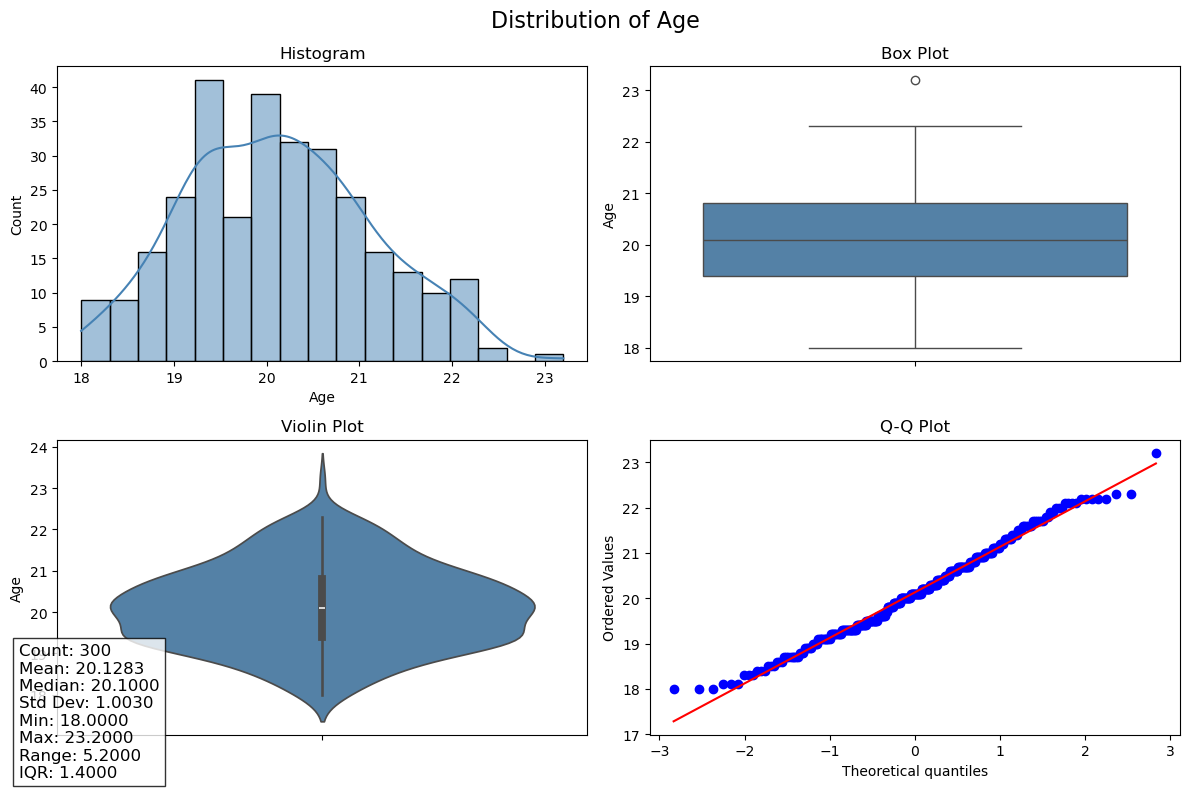

In [19]:
# Visualize the Age distribution with noise applied
visualize_distribution(df, 'Age')

In [20]:
display(df)

,ID_Number,Gender,Age,Weekly_Social_Media_Usage_Min,SMDT_Item1,SMDT_Item2,SMDT_Item3,SMDT_Item4,SMDT_Total,OHQ_Sum,OHQ_Mean
0,1,Male,20.1,881.0,3.0,3.0,2.0,3.0,11.0,94.0,3.241379
1,2,Other,19.4,561.0,2.0,2.0,2.0,3.0,9.0,99.0,3.413793
2,3,Female,22.2,717.0,2.0,3.0,3.0,3.0,19.0,107.0,3.689655
3,4,Female,20.7,913.0,3.0,3.0,3.0,4.0,13.0,104.0,3.586207
4,5,Male,18.1,659.0,4.0,4.0,4.0,4.0,16.0,106.0,3.655172
...,...,...,...,...,...,...,...,...,...,...,...
295,296,Female,20.1,754.0,2.0,3.0,2.0,3.0,14.0,100.0,3.448276
296,297,Female,20.4,782.0,3.0,3.0,3.0,3.0,12.0,98.0,3.655172
297,298,Male,19.2,821.0,3.0,4.0,3.0,4.0,14.0,95.0,3.275862
298,299,Female,20.7,524.0,3.0,3.0,3.0,3.0,12.0,100.0,3.448276
